# Step1:Importing the Libraries

In [30]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D,MaxPooling2D
from keras import  applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications import InceptionResNetV2
from keras import models
from keras_preprocessing import image as im

from keras.models import load_model

# Step2:Loading the images and Visualizing them

In [8]:
def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w
Benign=os.listdir("data/train/benign")
Malignant=os.listdir("data/train/malignant")
train=[Benign,Malignant]
Height_Width=[]

for image in Benign:
    Height_Width.append((get_dims("data/train/benign/"+image)[0],get_dims("data/train/benign/"+image)[1]))
Benign=['Benign' for _ in Benign]    
for image in Malignant:
    Height_Width.append((get_dims("data/train/malignant/"+image)[0],get_dims("data/train/malignant/"+image)[1]))
Malignant=['Malignant' for _ in Malignant]
train=Benign+Malignant
df=pd.DataFrame({'Disease':train,'Height_Width':Height_Width})

<Figure size 1008x720 with 0 Axes>

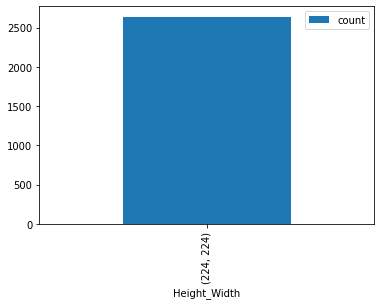

In [9]:
sizes=df.groupby(['Height_Width']).size().reset_index().rename(columns={0:'count'})
#Size Distribution
plt.figure(figsize=(14, 10))
sizes.plot.bar(x='Height_Width',y='count')



From the above bar graph we can see that all the images are of same size

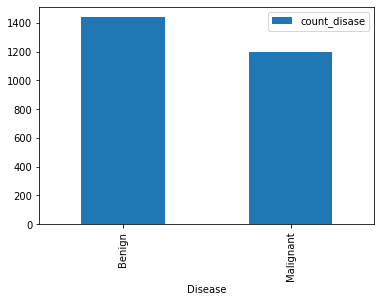

In [10]:
sizes=df.groupby('Disease').size().reset_index().rename(columns={0:'count_disase'})
sizes.plot.bar(x='Disease',y='count_disase')

The above plot tells us that the dataset is almost balanced

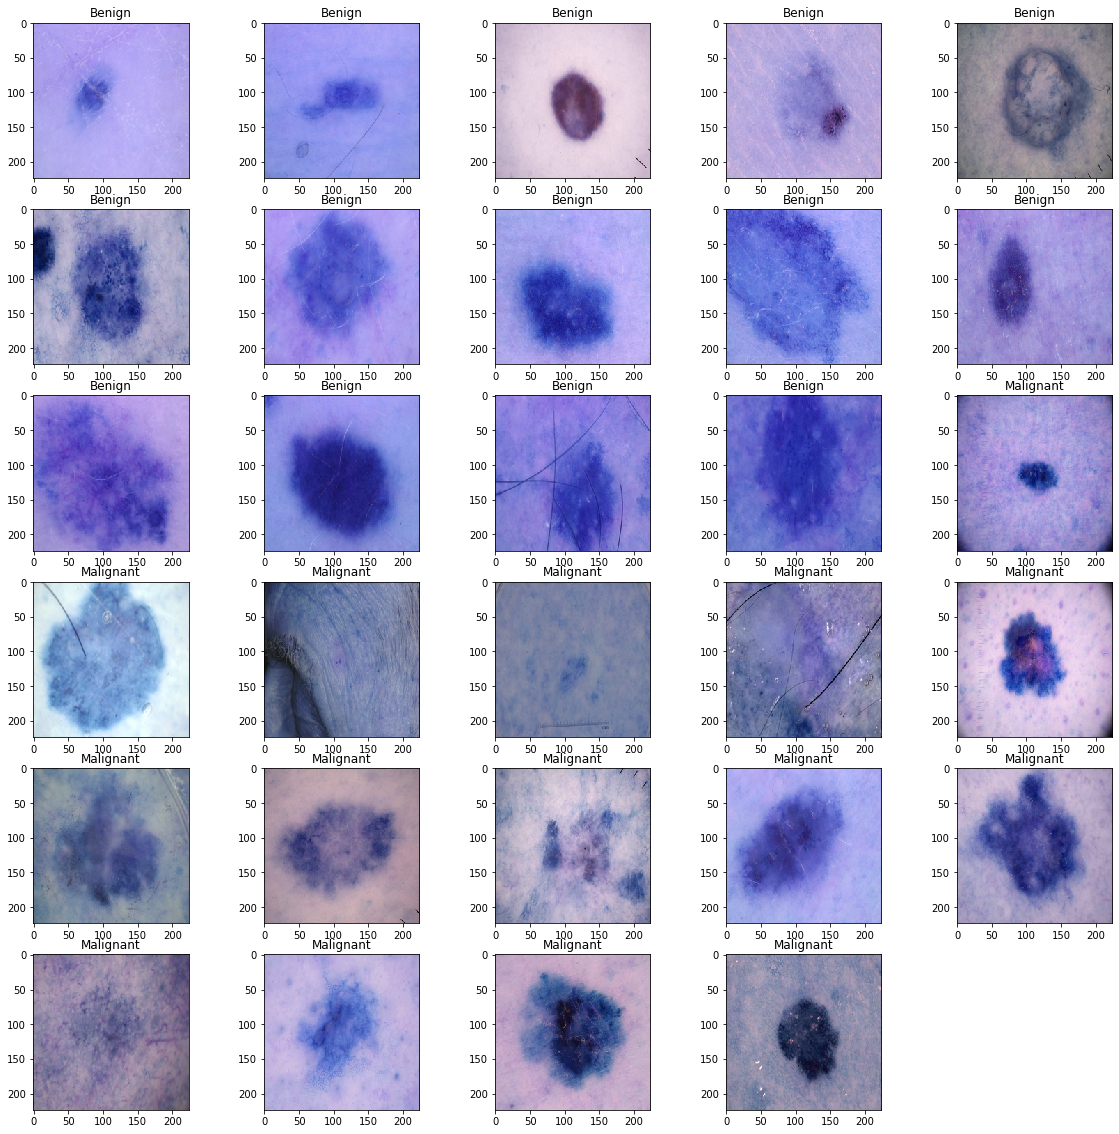

In [11]:
# Display first 29 images of moles, and how they are classified
w=80
h=100
fig=plt.figure(figsize=(20,20))
columns = 5
rows = 6
x_train=[]
for image in os.listdir("data/train/benign")[:15]:
    x_train.append("data/train/benign/"+image)
for image in os.listdir("data/train/malignant")[:15]:
    x_train.append("data/train/malignant/"+image)        
for i in range(1, columns*rows ):
    ax = fig.add_subplot(rows, columns, i)
    if i<15:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(cv2.imread(x_train[i]), interpolation='nearest')    
plt.show()

In [12]:
#Preprocessing Data
datagen=ImageDataGenerator(rescale=1./255,samplewise_center=True, samplewise_std_normalization=True, 
                                 rotation_range=5,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 validation_split = 0.25)
test_datagen=ImageDataGenerator(rescale=1./255)

In [14]:
#Data Generator
train_generator = datagen.flow_from_directory(
    directory=r"data/train",
    target_size=(80, 80),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    subset='training',
    seed=42
)
valid_generator=datagen.flow_from_directory(
    directory=r"data/train",
    target_size=(80, 80),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    subset='validation',
    seed=42
)

Found 1978 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


# Step3: Building a Model

In [19]:

def build(input_shape= (80,80,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))


    model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))


    model.add(Conv2D(16, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

# Step4: Training the model

In [20]:
model=build()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 80, 80, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 32)       

In [21]:
checkpointer1=ModelCheckpoint(filepath='model.hdf5', 
                            verbose=1, save_best_only=True,monitor='val_accuracy',mode='max')
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
epochs=10
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs, callbacks = [checkpointer1],use_multiprocessing=True)    

Epoch 1/10
61/61 [==============================] - 10s 166ms/step - loss: 0.6992 - accuracy: 0.4640 - val_loss: 0.7174 - val_accuracy: 0.5625

Epoch 00001: val_accuracy improved from -inf to 0.56250, saving model to model.hdf5
Epoch 2/10
61/61 [==============================] - 10s 169ms/step - loss: 0.6483 - accuracy: 0.5689 - val_loss: 0.7621 - val_accuracy: 0.6762

Epoch 00002: val_accuracy improved from 0.56250 to 0.67624, saving model to model.hdf5
Epoch 3/10
61/61 [==============================] - 10s 164ms/step - loss: 0.5785 - accuracy: 0.7400 - val_loss: 0.5082 - val_accuracy: 0.7097

Epoch 00003: val_accuracy improved from 0.67624 to 0.70973, saving model to model.hdf5
Epoch 4/10
61/61 [==============================] - 10s 164ms/step - loss: 0.5130 - accuracy: 0.7806 - val_loss: 0.6344 - val_accuracy: 0.7289

Epoch 00004: val_accuracy improved from 0.70973 to 0.72887, saving model to model.hdf5
Epoch 5/10
61/61 [==============================] - 10s 165ms/step - loss: 0.54

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


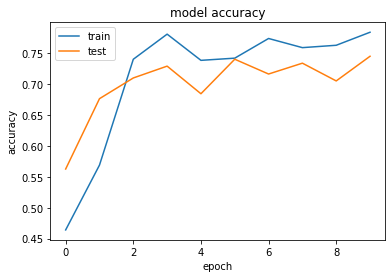

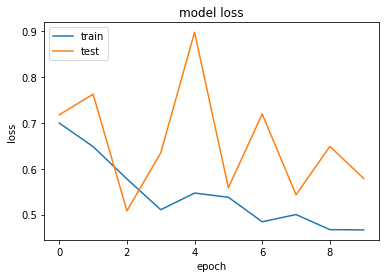

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualizing the weights between layers

The first layer acts is retaining the full shape of the image, although there are several filters that are not activated and are left blank. At that stage, the activations retain almost all of the information present in the initial picture. As we go deeper in the layers, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level features. Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image. As mentioned above, the model stucture is overly complex to the point where we can see our last layers actually not activating at all, there's nothing more to learn at that point.

In [23]:
classifier=load_model('./model.hdf5')

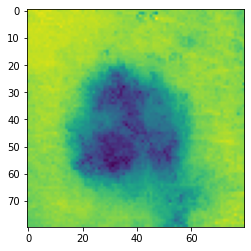

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


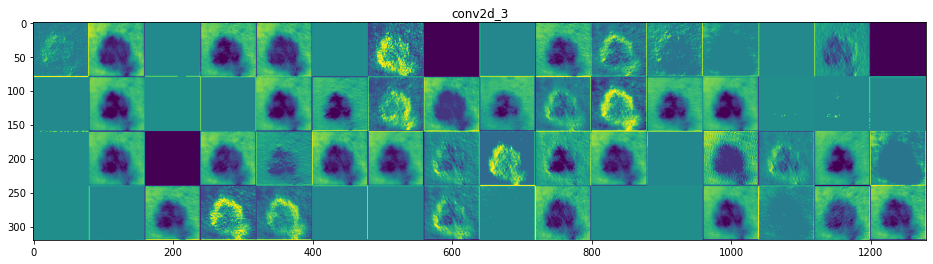

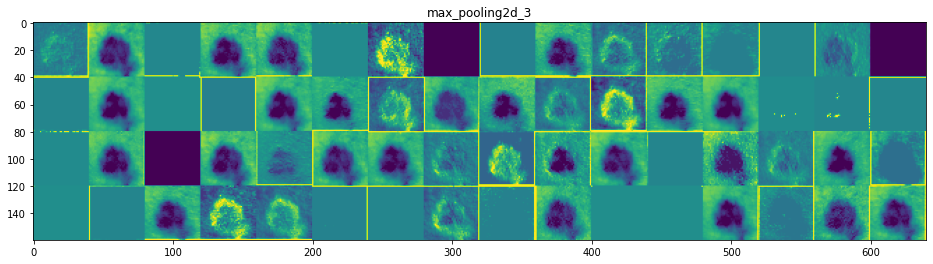

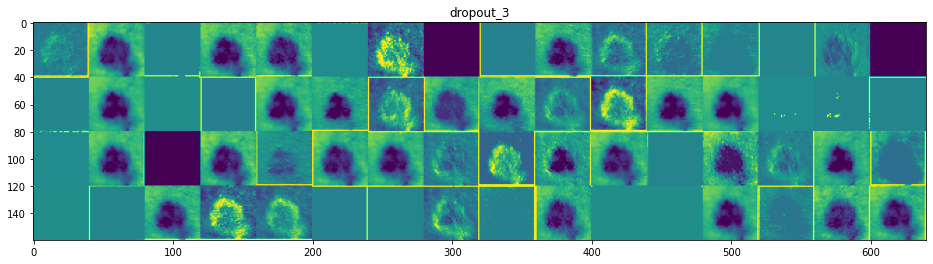

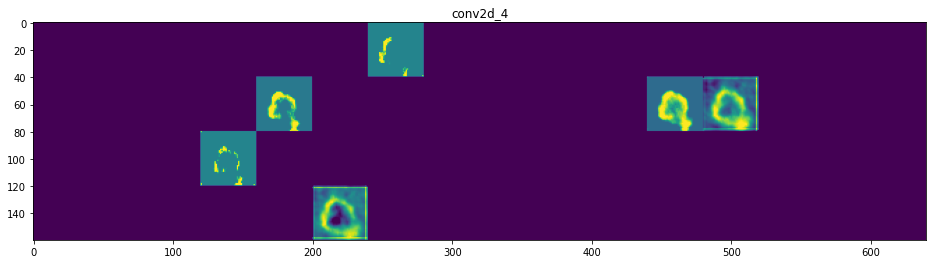

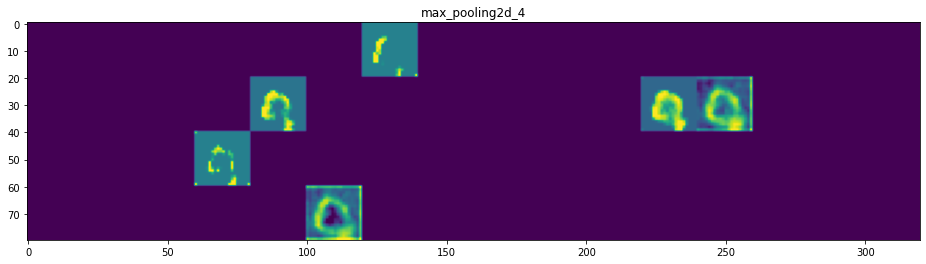

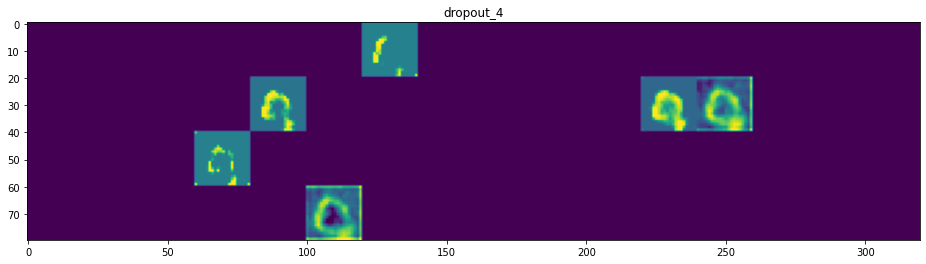

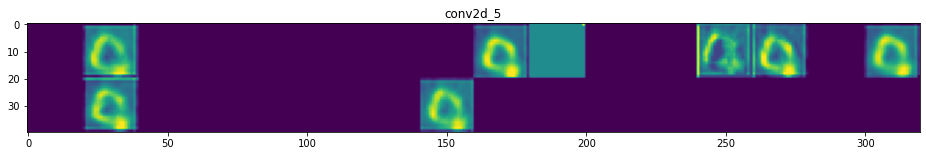

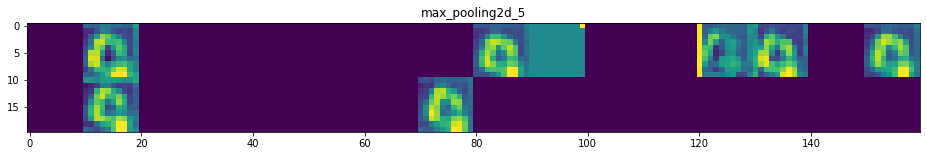

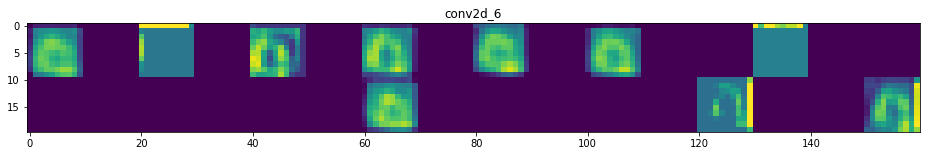

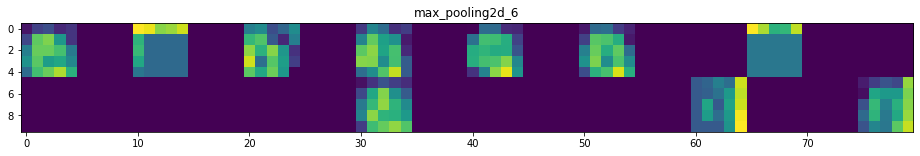

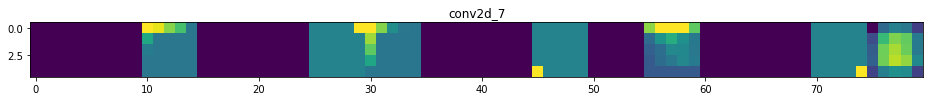

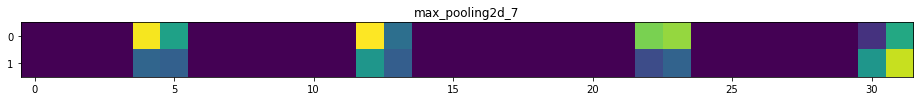

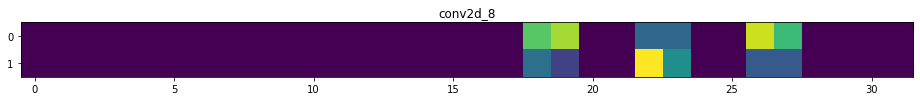

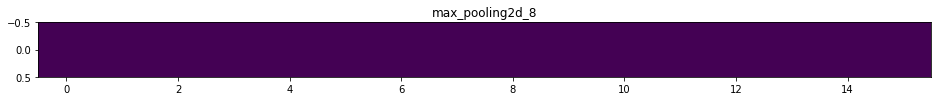

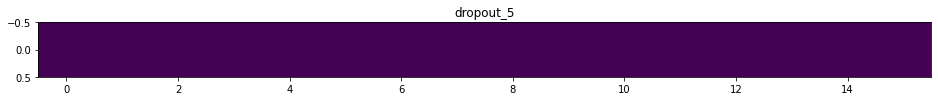

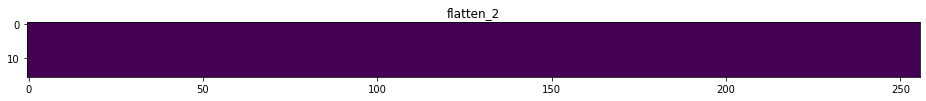

In [42]:
import numpy as np
img = im.load_img('data/test/benign/10.jpg', target_size=(80,80,3))
#list is coverted to array
img_tensor = im.img_to_array(img)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
#now we convert it to grayscale
img=rgb2gray(img_tensor)

plt.imshow(img)
plt.show()

img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

layer_outputs = [layer.output for layer in classifier.layers[:-2]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
img_tensor=np.array(img_tensor).reshape((80,80,3))
img_tensor = np.expand_dims(img_tensor, axis=0)
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation
layer_names = []
for layer in classifier.layers[:-2]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    #print(layer_activation.shape)
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    try:
      for col in range(n_cols): # Tiles each filter into a big horizontal grid
          for row in range(images_per_row):
              channel_image = layer_activation[0,:, :,col * images_per_row + row]
              channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image
    except:
      print()                      
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')